# Question Answering on SQuAD evaluation
### Project overview
This project explores extractive Question Answering using a Transformer-based model and the SQuAD dataset. It includes manual testing, systematic evaluation with Exact Match and F1 metrics, analysis of performance versus context and answer length, and full fine-tuning of the model on SQuAD.The goal is not only to apply a pretrained QA model, but to analyze its real behavior in detail, understand where it succeeds and fails, and evaluate how performance depends on context length and answer length

## Imports

In [1]:
# !pip install transformers[torch] datasets evaluate ipywidgets seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    DefaultDataCollator,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

from IPython.display import display
import warnings


In [59]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


## SQuAD dataset and baseline model

Let's use the SQuAD v1 dataset and a pretrained QA model from the `transformers` library.

In [6]:
datasets = load_dataset("squad")
datasets

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

Let's look at the structure

In [26]:
train_df = pd.DataFrame(datasets['train'])

In [64]:
train_df.head(15)

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...
5,5733bf84d058e614000b61be,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",When did the Scholastic Magazine of Notre dame...,"{'text': ['September 1876'], 'answer_start': [..."
6,5733bf84d058e614000b61bf,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",How often is Notre Dame's the Juggler published?,"{'text': ['twice'], 'answer_start': [441]}"
7,5733bf84d058e614000b61c0,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",What is the daily student paper at Notre Dame ...,"{'text': ['The Observer'], 'answer_start': [598]}"
8,5733bf84d058e614000b61bd,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",How many student news papers are found at Notr...,"{'text': ['three'], 'answer_start': [126]}"
9,5733bf84d058e614000b61c1,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",In what year did the student paper Common Sens...,"{'text': ['1987'], 'answer_start': [908]}"


In [30]:
init_set = train_df.head(5)


In [40]:
init_set.title.unique(),init_set.context.unique()

(array(['University_of_Notre_Dame'], dtype=object),
 array(['Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'],
       dtype=object))

In [66]:
for index, row in init_set.iterrows():
    print(row['question'])
    print(row['answers']['text'][0],"- answer starts at", row['answers']['answer_start'][0])
    print('*'*30)
    print()

To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Saint Bernadette Soubirous - answer starts at 515
******************************

What is in front of the Notre Dame Main Building?
a copper statue of Christ - answer starts at 188
******************************

The Basilica of the Sacred heart at Notre Dame is beside to which structure?
the Main Building - answer starts at 279
******************************

What is the Grotto at Notre Dame?
a Marian place of prayer and reflection - answer starts at 381
******************************

What sits on top of the Main Building at Notre Dame?
a golden statue of the Virgin Mary - answer starts at 92
******************************



So we see here that in the training dataset we have 5 examples of questions related to the same content with the answer_start number to match position of letters in the content where the answer starts 

## QA Model

let's use "distilbert-base-uncased-distilled-squad", it's based on BERT, but uses with distillation (so it's smaller and faster) and is already fine-tuned on the SQuAD dataset. The model is extractive, it looks at context and preidcts start and end token index (not letter as in the dataset)

In [7]:
model_name = "distilbert-base-uncased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

device(type='cuda')

#### Quick sanity check

We can take one example from the validation set and see what the baseline model predicts


In [75]:
def give_answer(model, user_question, user_context, repeat_context=False):
    """Run QA inference on a question and context pair.

    Parameters
    ----------
    user_question : str
        Question string.
    user_context : str
        Context paragraph that should contain the answer.
    repeat_context : bool
        If True, prints question and context before answering.
    """
    if repeat_context:
        print("Question:", user_question)
        print("Context:", user_context)

    inputs = tokenizer(
        user_question,
        user_context,
        return_tensors="pt",
        truncation=True,
        max_length=512,
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    start_idx = torch.argmax(outputs.start_logits, dim=-1).item()
    end_idx = torch.argmax(outputs.end_logits, dim=-1).item() + 1

    predicted_ids = inputs["input_ids"][0][start_idx:end_idx]
    predicted_answer = tokenizer.decode(predicted_ids, skip_special_tokens=True)

    return predicted_answer.strip()


In [9]:
example = datasets["validation"][0]
print("Question:", example["question"])
print("Context:", example["context"][:300], "...")
print("Ground truth answers:", example["answers"])

baseline_answer = give_answer(model, example["question"], example["context"])
print("\nBaseline prediction:", baseline_answer)


Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super B ...
Ground truth answers: {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}

Baseline prediction: denver broncos


We see that model is **passing basic sanity**, but let's check out model's logic further, for example let's ask simple questions like

In [11]:
give_answer(model, "Mike's friend Sarah left for the US in June.", "Where did Mike's friend go?")

'the us'

In [17]:
give_answer(model, "Mike's friend Sarah left for the US in June.", "When did Mark leave?")

'june'

So the model is of course not flawless, when it doesn't have an answer to a question it will hallucinate it, or it will get confused and answer incorrectly with full confidence. It's not unusual, we can use it

## 5. Evaluation by context and answer length

Next we evaluate the baseline model over a subset of the validation set and track:

* Whether the prediction exactly matches the ground truth (Let's consider an answer to be successful ONLY when we have exact start and end positions)
* F1 score for the predicted span (for word overlap measuring)
* Context length (in tokens)
* Answer length (in tokens)

This lets us understand for which lengths the model performs well or poorly, when performance starts to degrade due to too much information.
We expect to see that short contexts and short answers are easier, whereas long contexts give more chances for mistakes



In [92]:
squad_metric = evaluate.load("squad")

def evaluate_single_example(idx, model, split="validation", compute_lengths=True):
    """Run the model on one SQuAD example and collect info.

    Returns a dict with prediction, ground truth, and optional length features.
    """
    example = datasets[split][idx]
    question = example["question"]
    context = example["context"]
    answers = example["answers"]

    predicted_answer = give_answer(model, question, context)
    expected_answer = answers["text"][0]
    answer_start = answers["answer_start"][0]
    prediction = {"id": str(idx), "prediction_text": predicted_answer}
    reference = {
        "id": str(idx),
        "answers": {"text": [expected_answer], "answer_start": [answer_start]},
    }
    metric_result = squad_metric.compute(predictions=[prediction], references=[reference])

    result = {
        "row": idx,
        "question": question,
        "predicted_answer": predicted_answer,
        "expected_answer": expected_answer,
        "answer_start": answer_start,
        "exact_match_score": metric_result["exact_match"],
        "f1_score": metric_result["f1"],
    }

    if compute_lengths:
        context_tokens = tokenizer(context, add_special_tokens=False)["input_ids"]
        answer_tokens = tokenizer(expected_answer, add_special_tokens=False)["input_ids"]
        result["context_length"] = len(context_tokens)
        result["answer_length"] = len(answer_tokens)

    result["result"] = bool(metric_result["exact_match"] > 0)

    return result


In [46]:
validation_with_length = []
n_examples = 2000

for i in range(n_examples):
    validation_with_length.append(evaluate_single_example(i,model, split="validation", compute_lengths=True))

df_with_length = pd.DataFrame(validation_with_length)
df_with_length.head()


,row,question,predicted_answer,expected_answer,answer_start,exact_match_score,f1_score,context_length,answer_length,result
0,0,Which NFL team represented the AFC at Super Bo...,denver broncos,Denver Broncos,177,100.0,100.0,157,2,True
1,1,Which NFL team represented the NFC at Super Bo...,carolina panthers,Carolina Panthers,249,100.0,100.0,157,2,True
2,2,Where did Super Bowl 50 take place?,levi ' s stadium,"Santa Clara, California",403,0.0,0.0,157,4,False
3,3,Which NFL team won Super Bowl 50?,,Denver Broncos,177,0.0,0.0,157,2,False
4,4,What color was used to emphasize the 50th anni...,gold,gold,488,100.0,100.0,157,1,True


### Distribution of context lengths


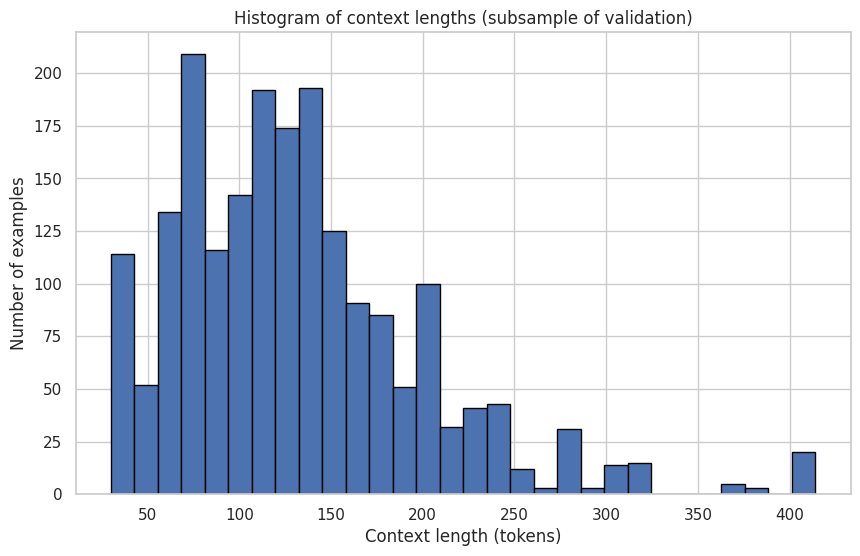

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(df_with_length["context_length"], bins=30, edgecolor="black")
plt.title("Histogram of context lengths (subsample of validation)")
plt.xlabel("Context length (tokens)")
plt.ylabel("Number of examples")
plt.grid(True)
plt.show()


### Binning context and answer lengths

To see clearer patterns, we bin the context and answer lengths and compute the average exact match and F1 scores per bin.


In [81]:
context_bins = [0, 50, 100, 150, 200, 250, float("inf")]
context_labels = ["0–50", "50–100", "100–150", "150–200", "200–250", "250+"]

answer_bins = [0, 1, 3, 5, 10, 20, float("inf")]
answer_labels = ["1", "1–3", "3–5", "5–10", "10–20", "20+"]


In [80]:
def get_binned_matchj_and_f1(df, context_bins, context_labels, answer_bins, answer_labels):
    df["context_length_bin"] = pd.cut(df["context_length"], bins=context_bins, labels=context_labels, include_lowest=True)
    df["answer_length_bin"] = pd.cut(df["answer_length"], bins=answer_bins, labels=answer_labels, include_lowest=True)    
    exact_match_cm = df.pivot_table(
    index="context_length_bin",
    columns="answer_length_bin",
    values="exact_match_score",
    aggfunc="mean",
    )

    f1_cm = df.pivot_table(
    index="context_length_bin",
    columns="answer_length_bin",
    values="f1_score",
    aggfunc="mean",
    )
    plt.figure(figsize=(12, 6))
    sns.heatmap(exact_match_cm, annot=True, fmt=".2f")
    plt.title("Average exact match by context and answer length bins")
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(f1_cm, annot=True, fmt=".2f")
    plt.title("Average F1 score by context and answer length bins")
    plt.show()


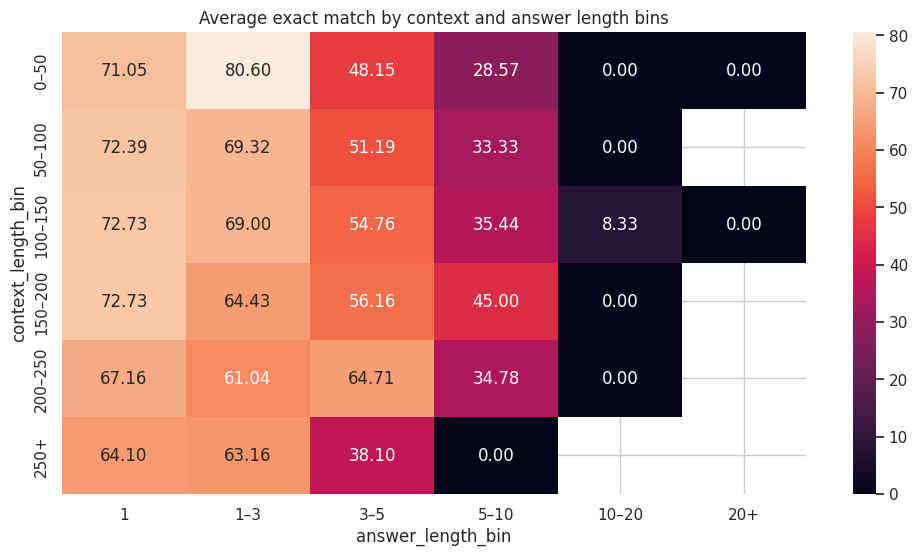

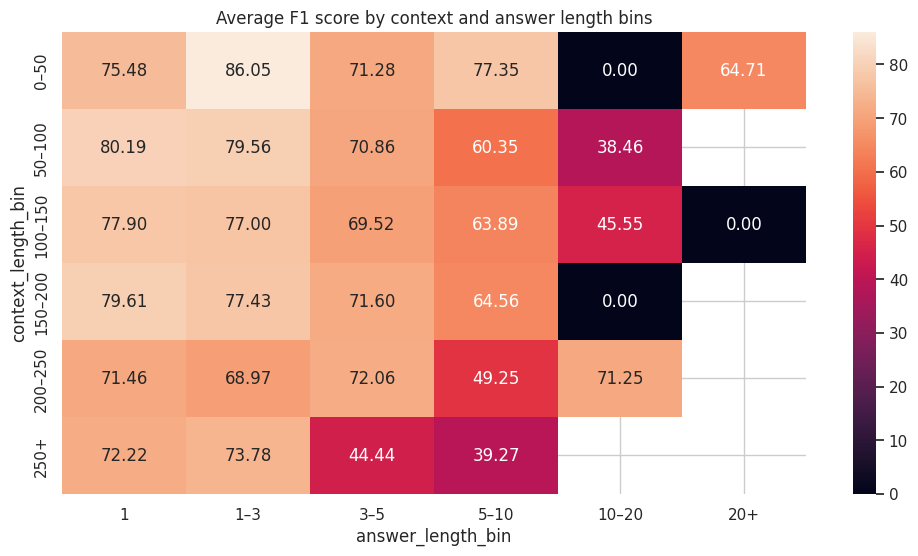

In [82]:
get_binned_matchj_and_f1(df_with_length, context_bins, context_labels, answer_bins, answer_labels)

#### Short conclusion

The baseline model performs best on short answers (1–5 tokens) and moderate context lengths (50–150 tokens). As answer spans grow longer, Exact Match drops quickly, even when F1 remains moderate. This indicates that the model often identifies the correct region but struggles with precise boundary prediction for long answers.

Performance for very long contexts (200+ tokens) is less stable, likely due to increased ambiguity and a smaller number of examples in those bins. Overall, the baseline is most reliable for compact factual extraction, while longer reasoning-heavy spans remain difficult.

## 6. Fine-tuning the model on SQuAD

We now CAN fine-tune the model on the SQuAD training set (even though it's already fine-tuned, to see if there are any ways to improve it). 
We use a standard span-prediction setup:

1. Tokenize (question, context) pairs with overlapping windows for long contexts.
2. Align token positions with the character-level answer spans.
3. Train the model to predict start and end token positions.


In [53]:
data_collator = DefaultDataCollator(return_tensors="pt")

def prepare_train_features(examples):
    examples["question"] = [q.lstrip() for q in examples["question"]]

    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=512,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized.sequence_ids(i)
        sample_idx = sample_mapping[i]
        answers = examples["answers"][sample_idx]

        if len(answers["answer_start"]) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
            continue

        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            start_pos = token_start_index - 1

            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            end_pos = token_end_index + 1

            start_positions.append(start_pos)
            end_positions.append(end_pos)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    return tokenized


In [54]:
tokenized_ds = {}
tokenized_ds["train"] = datasets["train"].map(
    prepare_train_features,
    batched=True,
    remove_columns=datasets["train"].column_names,
    desc="Tokenizing train",
)

tokenized_ds["validation"] = datasets["validation"].map(
    prepare_train_features,
    batched=True,
    remove_columns=datasets["validation"].column_names,
    desc="Tokenizing validation",
)


Tokenizing train:   0%|          | 0/87599 [00:00<?, ? examples/s]

Tokenizing validation:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [55]:
batch_size = 16
data_collator = DefaultDataCollator(return_tensors="pt")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    start_logits, end_logits = predictions

    start_predictions = np.argmax(start_logits, axis=1)
    end_predictions = np.argmax(end_logits, axis=1)

    start_labels = labels[0]
    end_labels = labels[1]

    start_accuracy = (start_predictions == start_labels).mean()
    end_accuracy = (end_predictions == end_labels).mean()
    exact_match = ((start_predictions == start_labels) & (end_predictions == end_labels)).mean()

    return {
        "start_accuracy": float(start_accuracy),
        "end_accuracy": float(end_accuracy),
        "exact_match": float(exact_match),
    }


### Training configuration

We use a relatively small learning rate and a few epochs, with evaluation every fixed number of steps and early stopping.


In [61]:
training_args = TrainingArguments(
    output_dir="qa_squad_model",
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    warmup_steps=200,
    weight_decay=0.01,
    max_grad_norm=0.5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=1,
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=200,
    dataloader_drop_last=False,
    dataloader_num_workers=2,
    fp16=torch.cuda.is_available(),
    seed=42,
    data_seed=42,
    report_to=None,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


In [62]:
train_result = trainer.train()
train_result

Step,Training Loss,Validation Loss,Start Accuracy,End Accuracy,Exact Match
1000,0.766900,1.164292,0.667702,0.707886,0.560888
2000,0.750900,1.124048,0.675136,0.709204,0.566441
3000,0.729100,1.139523,0.674760,0.712404,0.569923
4000,0.739700,1.145752,0.677677,0.712686,0.571711


TrainOutput(global_step=4000, training_loss=0.7249098510742188, metrics={'train_runtime': 89.3506, 'train_samples_per_second': 1963.366, 'train_steps_per_second': 122.73, 'total_flos': 8361798402048000.0, 'train_loss': 0.7249098510742188, 'epoch': 0.7295276308590188})

### Training and validation loss curves


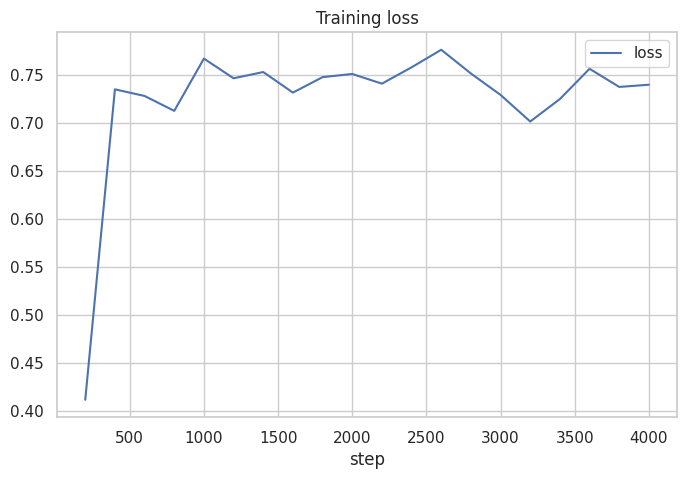

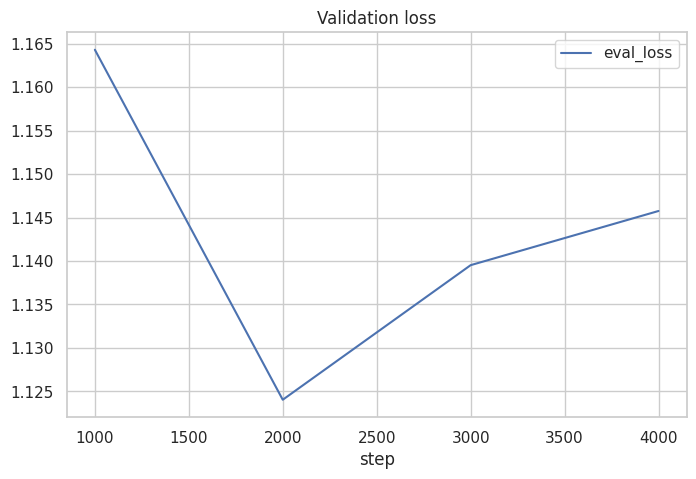

In [63]:
train_logs = [log for log in trainer.state.log_history if "loss" in log and "eval_loss" not in log]
val_logs = [log for log in trainer.state.log_history if "eval_loss" in log]

train_loss_df = pd.DataFrame(train_logs)
val_loss_df = pd.DataFrame(val_logs)

if not train_loss_df.empty:
    train_loss_df.plot(x="step", y="loss", title="Training loss")
    plt.show()

if not val_loss_df.empty:
    val_loss_df.plot(x="step", y="eval_loss", title="Validation loss")
    plt.show()


### Conclusion
The validation loss reaches a minimum early and then increases while training loss remains stable, indicating early overfitting and explaining why fine-tuning did not improve validation performance. Still, lets visualiza results to CM

In [70]:
fine_tuned_model = trainer.model
fine_tuned_model.to(device)
fine_tuned_model.eval()


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
     

In [77]:
    
validation_with_length_ft = []
for i in tqdm(range(2000)):
    validation_with_length_ft.append(evaluate_single_example(i, fine_tuned_model, 'validation', True))

df_with_length_ft = pd.DataFrame(
    validation_with_length_ft,
    columns = ['result', 'predicted_answer', 'expected_answer', 'row',
               'question', 'answer_start', 'context_length', 'answer_length']
)




  0%|          | 0/2000 [00:00<?, ?it/s]

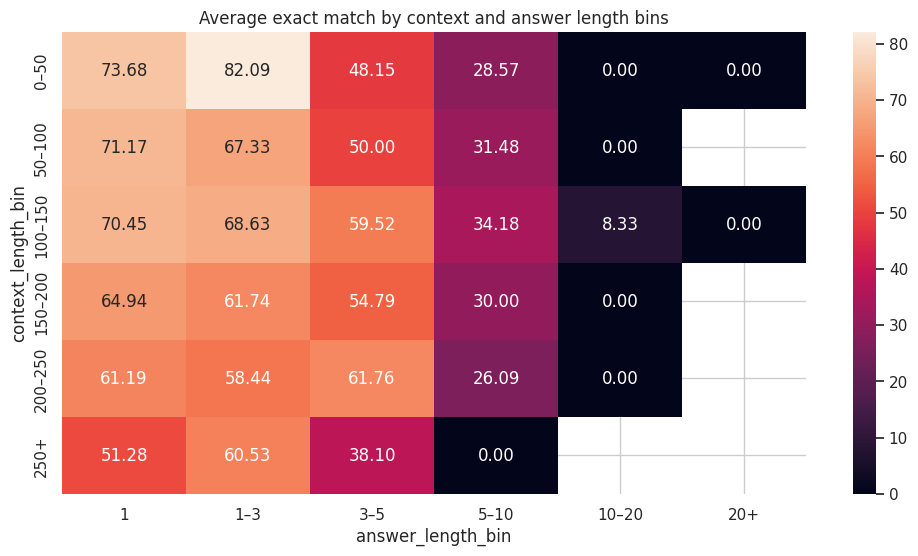

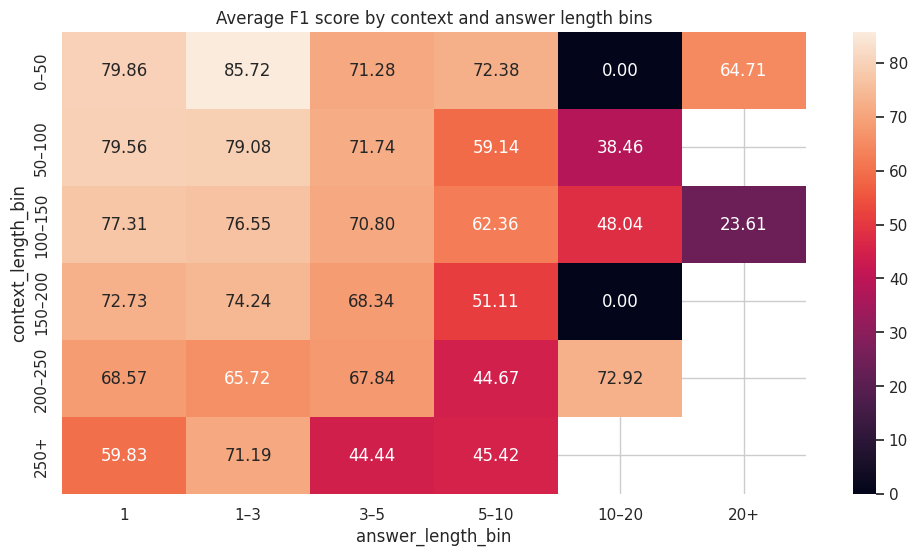

In [83]:
get_binned_matchj_and_f1(df_with_length_ft, context_bins, context_labels, answer_bins, answer_labels)

In [85]:
print(df_with_length["f1_score"].mean(),
      df_with_length_ft["f1_score"].mean())
print(df_with_length["exact_match_score"].mean(),
      df_with_length_ft["exact_match_score"].mean())
#yep, got worse!

73.90172014202577 72.42212374387047
62.25 60.45


We can confirm that the results got worse after finetuning

### Conclusion

The pretrained DistilBERT QA model already demonstrates strong performance on SQuAD-style extractive questions, achieving solid Exact Match and F1 without any additional training.
Manual probing confirms that when an answer is not clearly present in the context, the model still produces a confident but incorrect span, which is a typical issue.

Systematic evaluation shows that:
*  Performance is highest for short answers (1–5 tokens).
* Boundary prediction becomes increasingly unreliable as answer length grows.
* Longer contexts introduce additional ambiguity, reducing Exact Match even when partial overlap (F1) is still reasonable.

Fine-tuning the already SQuAD-trained model on the same dataset did not improve validation performance and slightly reduced both F1 and Exact Match. But this highlights only that fine-tuning a model on the same data distribution it was originally trained on does not guarantee improvement.
